ka/D 100.0
D 0.01 rm 0.005
tm 0.0025 tv 0.003025
factor 1.0 rv 0.005
k 1.0
acceptance prob 14.493132212
simdt 0.000172495493965
factor 1.1 rv 0.0055
k 0.999476615462
acceptance prob 14.4855467307
simdt 0.000208828845486
diff 0.0146515151515


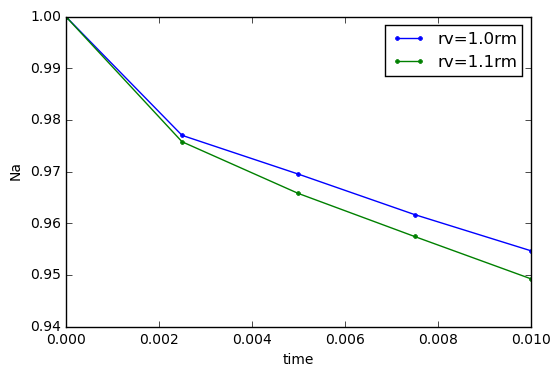

In [3]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
rng = core.GSLRandomNumberGenerator()
pi = math.pi

simrun = 30
L = 2.5
rm = 0.005
factors = [1.,1.1]
D = 0.01
Dt = 2*D
Rt = 2*rm
ka = 1.
H = 3*rm*2
dur = 0.01#3.
taum = ((2*rm)**2)/4./D
tauv = ((2*factors[1]*rm)**2)/4./D
ori = Real3(0.5*H,0,0)
unit0 = Real3(0,0,L)
unit1 = Real3(0,L,0)
w1 = spatiocyte.SpatiocyteWorld(Real3(H,L,L),rm)
cs = w1.row_size()
ls = w1.layer_size()
Nmv = cs*ls
At = L*L
Nt = 200
#Av = math.pi*rm*rm
#phi = 2.*Nt*Av/At
print 'ka/D',str(ka/D)
#print 'total number of voxels',Nmv
print 'D',D,'rm',rm
print 'tm',taum,'tv',tauv


def runsim(r,kk):
    rng.seed(run)
    w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),r,rng)
    cs = w.row_size()
    ls = w.layer_size()
    Nmv = cs*ls    
    #x,y,z = w.actual_lengths()
    w.bind_to(model)
    w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
    w.add_molecules(Species('A'),Nt)
    w.add_molecules(Species('B'),Nt)
    sim = spatiocyte.SpatiocyteSimulator(w)
    simdt = sim.dt()
    obs = FixedIntervalNumberObserver(taum, ('A', 'B'))
    sim.run(dur,obs)
    data=obs.data()
    dat = np.array(data)
    #print 'area fraction of all particle', Nt*2./Nmv
    #print 'alpha',sim.calculate_alpha(model.reaction_rules()[0])
    return dat,simdt

def phix(x):
    return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def getkk(factor,rv):
    if (factor!=1):
        #tauv = (2*rv)**2/4/D/2
        #dtau = tauv-taum
        #print 'dtau',dtau
        #dt = dtau/100#fine resolution needed for produce accurate numerical integration
        #kts = [kt(t-taum) for t in np.arange(taum,tauv,dt)]
        #ktm = np.trapz(kts,dx=dt)/dtau
        kk = 0.99947661546171029*ka#ktm
    else:
        kk=ka
    return kk

def createmodel(ka,D,rm):
    with species_attributes():
        A| B | {'D':str(D),'radius':str(rm),'location':'M'}
    with reaction_rules():
        A + B > B | ka    
    return get_model()

diff = []
for factor in factors:
    rv = factor*rm
    print 'factor',str(factor),'rv',str(rv)
    Na = np.zeros(int(dur/taum)+1)
    kk = getkk(factor,rv)
    print 'k',kk
    Pacc = kk*(2*math.sqrt(2)+4*math.sqrt(3)+3*math.sqrt(6)+math.sqrt(22))**2 / 72/(2*D)/(6*math.sqrt(2)+4*math.sqrt(3)+3*math.sqrt(6))
    print 'acceptance prob',Pacc
    model=createmodel(kk,D,rm)
    for run in range(int(simrun*factor)):
        dat,simdt = runsim(rv,kk) 
        Na += dat[:,1]
    print 'simdt',simdt
    t = dat[:,0]   
    Na = Na/int(simrun*factor)
    diff.append(Na)
    plt.plot(t,Na/Nt,'.-',label='rv='+str(factor)+'rm')
print 'diff',sum(abs(diff[0]-diff[1])/Nt)
plt.xlabel('time')
plt.ylabel('Na')
plt.legend(loc='best')



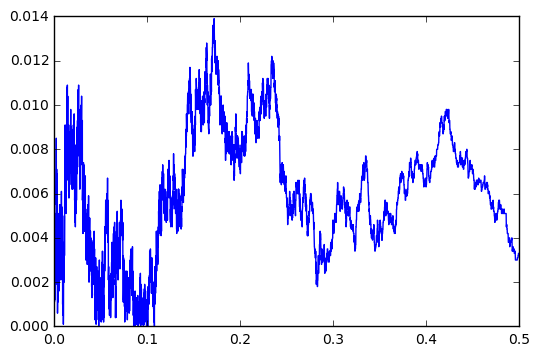

In [39]:
plt.plot(t,abs(diff[0]-diff[1])/Nt)

tm 0.005
walk time rm 0.00125
walk time rv 0.005
ka 1.0
dtau 0.00375
1.0
kt exact 1.0


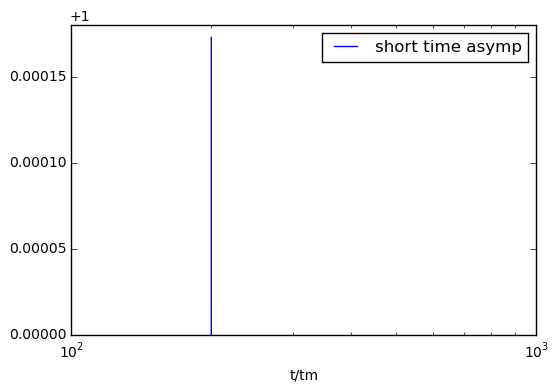

In [84]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
from scipy import special
from scipy import integrate
import matplotlib.pyplot as plt
D=0.01
rm=0.005
rv = 2*rm
ka=1.
Dt = 2*D
Rt = 2*rm
tm = (Rt)**2/Dt
pi=math.pi
twrm = (2*rm)**2/4/Dt
twrv = (2*rv)**2/4/Dt
dtau = twrv-twrm
print 'tm',tm
print 'walk time rm',twrm
print 'walk time rv',twrv

def phix(x):
    return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def kt(t):
    p1 = 0.0791183
    p2 = 0.935916
    p3 = 2.62231
    p4 = 12.9791
    p5 = 8.70808
    E = math.sqrt(p4*Dt*ka*t/Rt/Rt/(ka+p5*Dt))
    denom = Dt + p1*ka*math.log(p2+(p3*Dt*t/Rt/Rt)+E)
    return ka*Dt/denom

def kt2(t):#johnson eq14, shorttime RBC
    A = ka/(2*pi*Dt)
    B = t/tm
    return 2*pi*Dt*(0.5-(A*math.sqrt(B/pi))-(A*0.5*B*math.sqrt(B/pi))+
                    (A*phix(A*math.sqrt(B))*(1-(pi*Dt/ka)+(A*B)+(0.5*A*A*B*B))))

func = lambda u,t: (math.exp(-Dt*u*u*t)-1)/u/(
    ((ka*special.jv(0,Rt*u)+(2*pi*Rt*u*Dt*special.jv(1,Rt*u)))**2)+
 ((ka*special.yn(0,Rt*u)+(2*pi*Rt*u*Dt*special.yn(1,Rt*u)))**2))

def kte(tt): # integration of exact solution.
    y,err = integrate.quad(func,0,np.inf,args=tt)
    return y*8*ka*ka*Dt/pi + ka

#dt = dtau/100#fine resolution needed for produce accurate numerical integration
#kts = [kt(t-twrm) for t in np.arange(twrm,twrv,dt)]
#ktm = np.trapz(kts,dx=dt)/dtau

print 'ka',ka
print 'dtau',dtau
#print 'ka_',ktm
print kt2(0)
print 'kt exact',kte(0)
tt1 = np.logspace(0.1*tm,3*tm,100)
tt2 = np.logspace(1e-6*tm,1e-2*tm,100)
#k1 = [kt(i) for i in tt]
k2 = [kt2(i) for i in tt2]
#plt.plot(tt1/tm,[k/k1[0] for k in k1],label='simple form')
plt.plot(tt2/tm,[k/k2[0] for k in k2],label='short time asymp')
plt.legend()
plt.xscale('log')
plt.xlabel('t/tm')

tm 0.0005
walk time rm 0.000125
walk time rv 0.00032
ka 10.0
dtau 0.000195
ka_ 4.18661194343


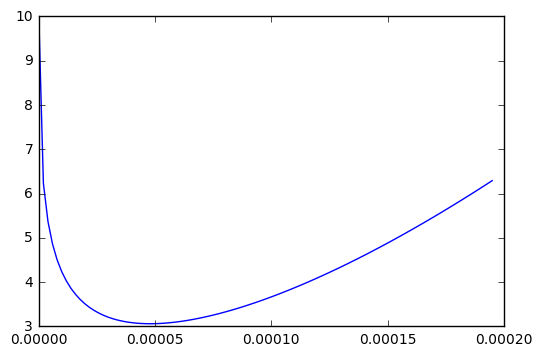

In [6]:
import math
D=0.1
rm=0.005
rv = 1.6*rm
ka=10.
Dt = 2*D
Rt = 2*rm
tm = (Rt)**2/Dt
pi=math.pi
A = ka/(4*pi*Dt)
twrm = (2*rm)**2/4/Dt
twrv = (2*rv)**2/4/Dt
dtau = twrv-twrm
print 'tm',tm
print 'walk time rm',twrm
print 'walk time rv',twrv

def phix(x):
    return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def kt(t):
    B = math.sqrt(Dt*t/Rt/Rt)
    phi = phix(2*A*B)
    D = 1-(pi*Dt/ka)+(2*A*B*B)+(2*A*A*B**4)
    k = 0.5-(2*A*B/math.sqrt(pi))-(A*B**3/math.sqrt(pi))+(2*A*phi*D)
    return 2*pi*Dt*k

dt = dtau/100#fine resolution needed for produce accurate numerical integration
kts = [kt(t-twrm) for t in np.arange(twrm,twrv,dt)]
ktm = np.trapz(kts,dx=dt)/dtau

print 'ka',ka
print 'dtau',dtau
print 'ka_',ktm

tt = np.linspace(0.0,dtau,100)
ktt = [kt(i) for i in tt]
plt.plot(tt,ktt)


In [11]:
import ecell4.core; print(ecell4.core.__file__)

/home/chew/wrk/ecell4/build/local/lib/python2.7/site-packages/ecell-4.0.4-py2.7-linux-x86_64.egg/ecell4/core.so
